## Heart Disease Classification

The purpose of this project is to classify whether a subject experiences cardiovascular disease (symptomatic narrowing of the arteries in the heart) based on different clinical and physiological variables. The full dataset can be downloaded at the UCI Machine Learning Repository [Heart Disease Data Set](https://archive.ics.uci.edu/ml/datasets/heart+disease). Most projects involving this dataset only incorporates the data from Cleveland Clinic; in this work we will include four available datasets:
1. Cleveland Clinic, OH, USA
2. University Hospital, Switzerland
3. V.A. Medical Center, Long Beach, CA, USA
4. Hungarian Institute of Cardiology, Hungary

First, we will read in the data from the four text files available in the `Data/heart_disease/` folder. We will follow with data cleaning, data exploration and data analysis to classify heart disease on this dataset. We wish to perform classification on whether a subject has heart disease, as indicated by whether they experience vascular narrowing of the heart arteries (like caused by plague buildup). In this dataset, this variable is indicated with `diameter_narrowing`, so we will use other features to predict whether subjects have heart disease (`1`) or do not have heart disease (`0`).

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import discriminant_analysis
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn import svm

In [2]:
# reading in data
def read_data(link, lines_per_subject, attrs_per_subject, database_id):
    with open(link, 'r') as f:
        content = f.read().splitlines()
        f.close()
    num_subjects = int(len(content) / lines_per_subject)
    lines = [line.split() for line in content]
    data = np.empty([num_subjects, attrs_per_subject])
    for n in range(0,num_subjects):
        line = lines[n*lines_per_subject : (n+1)*lines_per_subject]
        data_n = []
        for l in line:
            data_n += l
        data[n,:] = (data_n[:-1] + [database_id])
    return data

In [3]:
# based on documentation for this dataset, we set the number of lines, attributes and columns for each subject
lines_per_subject = 10
attrs_per_subject = 75 + 1 # add database_id
columns = ['id_del','ccf_del','age','sex','pain_loc','exer_pain','relieved_rest','pncaden_del',
           'chest_pain','rest_bp','htn_del','cholesterol','smoker_del','smoker_cigs_per_day_del',
           'smoker_years_del','fast_bs','hist_diabetes_del','hist_heart_del','rest_ecg','ekgmo_del',
           'ekgday_del','ekgyr_del','dig_del','prop_del','nitr_del','pro_del','diuretic_del',
           'exer_protocol','exer_dur','thaltime_del','met_del','exer_hr','rest_hr','exer_bp1',
           'exer_bp2','dummy_del','rest_bp_del','exer_angina','xhypo_del','oldpeak','exer_slope',
           'rest_amp','exer_amp','vessels_flouro_del','restckm_del','exerckm_del','rest_ejection_del',
           'rest_wall_del','exer_ejection_del','exer_wall_del','thal_del','thalsef_del','thalpul_del',
           'earlobe_del','cmo_del','cday_del','cyr_del','diameter_narrowing','lmt_del','ladprox_del',
           'laddist_del','diag_del','cxmain_del','ramus_del','om1_del','om2_del','rcaprox_del',
           'rcadist_del','lvx1_del','lvx2_del','lvx3_del','lvx4_del','lvf_del','cathef_del','junk_del','center_id']

In [4]:
link_switz = '../Data/heart_disease/switzerland.data'
data_switz = read_data(link_switz, lines_per_subject, attrs_per_subject, 0)
link_cleveland = '../Data/heart_disease/cleveland.data'
data_cleveland = read_data(link_cleveland, lines_per_subject, attrs_per_subject, 1)
link_longbeach = '../Data/heart_disease/long-beach-va.data'
data_longbeach = read_data(link_longbeach, lines_per_subject, attrs_per_subject, 2)
link_hungary = '../Data/heart_disease/hungarian.data'
data_hungary = read_data(link_hungary, lines_per_subject, attrs_per_subject, 3)

data_np = np.concatenate([data_switz, data_cleveland, data_longbeach, data_hungary], axis=0)
# columns from the documentation
data = pd.DataFrame(data_np, columns=columns)
data.drop(list(data.filter(regex='_del')), axis=1, inplace=True)
data.replace(-9, np.nan, inplace=True)

# Data cleaning

In [5]:
data.head()

,age,sex,pain_loc,exer_pain,relieved_rest,chest_pain,rest_bp,cholesterol,fast_bs,rest_ecg,...,rest_hr,exer_bp1,exer_bp2,exer_angina,oldpeak,exer_slope,rest_amp,exer_amp,diameter_narrowing,center_id
0,65.0,1.0,1.0,1.0,1.0,4.0,115.0,0.0,0.0,0.0,...,56.0,185.0,80.0,1.0,0.0,2.0,NaN,NaN,1.0,0.0
1,32.0,1.0,0.0,0.0,0.0,1.0,95.0,0.0,NaN,0.0,...,74.0,160.0,75.0,0.0,0.7,1.0,8.0,10.0,1.0,0.0
2,61.0,1.0,1.0,1.0,1.0,4.0,105.0,0.0,NaN,0.0,...,70.0,155.0,90.0,1.0,1.5,1.0,24.0,20.0,1.0,0.0
3,50.0,1.0,1.0,1.0,1.0,4.0,145.0,0.0,NaN,0.0,...,82.0,180.0,95.0,1.0,0.7,2.0,12.0,13.0,1.0,0.0
4,57.0,1.0,1.0,1.0,1.0,4.0,110.0,0.0,NaN,1.0,...,71.0,145.0,80.0,1.0,1.4,1.0,18.0,18.0,3.0,0.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899 entries, 0 to 898
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 899 non-null    float64
 1   sex                 899 non-null    float64
 2   pain_loc            617 non-null    float64
 3   exer_pain           617 non-null    float64
 4   relieved_rest       613 non-null    float64
 5   chest_pain          899 non-null    float64
 6   rest_bp             840 non-null    float64
 7   cholesterol         869 non-null    float64
 8   fast_bs             809 non-null    float64
 9   rest_ecg            897 non-null    float64
 10  exer_protocol       787 non-null    float64
 11  exer_dur            843 non-null    float64
 12  exer_hr             844 non-null    float64
 13  rest_hr             843 non-null    float64
 14  exer_bp1            836 non-null    float64
 15  exer_bp2            836 non-null    float64
 16  exer_ang

There are 899 rows in this dataset. Most columns have missing values, ranging from ~50 to more than 400 missing values. We will investigate each feature to decide whether we can keep the feature and apply imputation to fill in the missing values.

The variable we can interested in for prediction is `diameter_narrowing`, which indicates cardiovascular narrowing of the arteries and is a biomarker of heart disease. This variable does not have any missing values and is a categorical variable with integers from 0 to 4. Looking at the bar graph, we see that most subjects are classified as `0`, which mean no arterial narrowing. The remaing values `1`, `2`, `3` and `4` indicate the severity of the narrowing.

Since we are interested in classifying whether the subject has heart disease or not, instead of severity ratings, we will convert this `diameter_narrowing` variable to a binary variable, with `0` as no disease and `1` as heart disease.

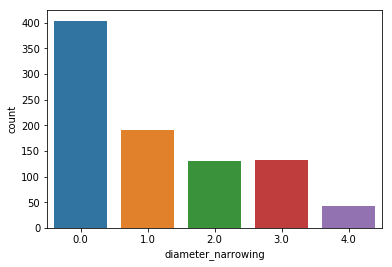

In [7]:
sns.countplot(x='diameter_narrowing',data=data)

In [8]:
# binary variable
data.loc[data['diameter_narrowing']>1, 'diameter_narrowing'] = 1

Now let's move on to cleaning the predictors, starting with `age`, which does not have any missing entries. The distribution plot is only very slightly skewed left, so we do not perform any skewness correction.

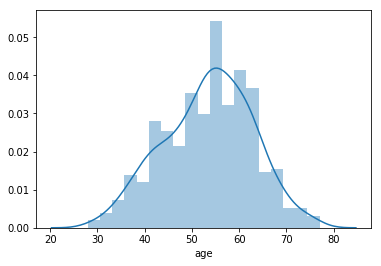

In [9]:
sns.distplot(data['age'])

For variables `pain_loc`, we see that the majority of non-null values is `1`, and only ~10% of the entries are `0`; this unbalanced feature can also be visualized in the bar graph below. Since the feature is so predominantly one value, we will drop this column.

In [10]:
data['pain_loc'].value_counts()

1.0    568
0.0     49
Name: pain_loc, dtype: int64

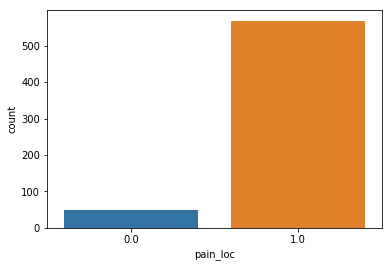

In [11]:
sns.countplot(x='pain_loc',data=data)
data.drop(columns=['pain_loc'], axis=1, inplace=True) # drop pain_loc column

On the other hand, `exer_pain` (which indicates whether subject experiences pain during physical exercise) is more balanced, with around 60% answered yes and 40% answered no. One option is to impute all missing values with the mode, which is `1`. 

However, looking at the bar graph between `exer_pain` and `exer_angina` (which is the experience of chest pain caused by reduced blood flow to the heart), we see an expected relationship. Within subjects who experience angina, the majority have pain during exercise; on the other hand, without angina, there are more subjects who do not experience exercise pain. Therefore, we will impute `exer_pain` based on `exer_angina`.

1.0    366
0.0    251
Name: exer_pain, dtype: int64


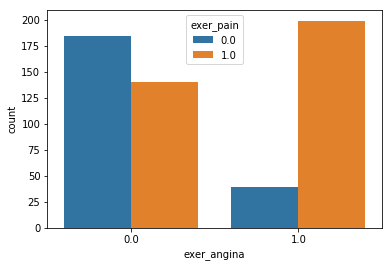

In [12]:
print(data['exer_pain'].value_counts())
sns.countplot(x='exer_angina',hue='exer_pain',data=data) 

In [13]:
# locations where exer_pain is null and exer_angina is not null
data.loc[(data['exer_pain'].isnull()) & (data['exer_angina'].notnull()), 'exer_pain'] = data['exer_angina']
data['exer_pain'].value_counts(dropna=False)

1.0    458
0.0    441
Name: exer_pain, dtype: int64

Variable `relieved_rest` has around 300 missing entries; 2/3 of the non-null entries is `1`, which means the subjects is relieved during the post-exercise rest. But let's explore `relieved_rest` further to see which method of imputation is best for this feature.

1.0    412
0.0    201
Name: relieved_rest, dtype: int64


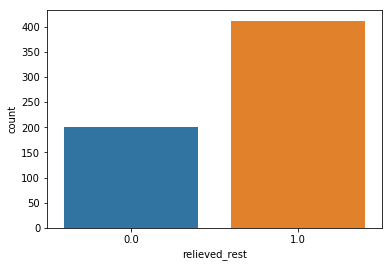

In [14]:
print(data['relieved_rest'].value_counts())
sns.countplot(x='relieved_rest', data=data)

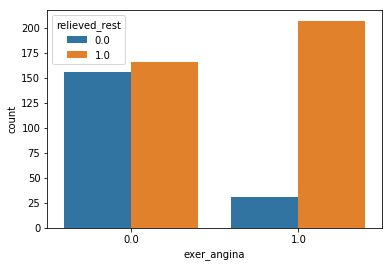

In [15]:
sns.countplot(x='exer_angina', hue='relieved_rest', data=data)

For the countplot above between `relieved_rest` and `exer_angina`, we see that if `exer_angina` is `1` then quite likely the subject will experience relieved-resting. Therefore, for the rows in which `relieved_rest` is null and `exer_angina` is `1`, we will fill with `1`.

The following countplot between `relieved_rest` and `sex` shows that males (`sex`=1) is more likely to experience exercise pain. Therefore, remaining null values in male subjects are filled with 1 as well. There are still 73 null values remaining after this procedure.

The remaining values, we will fill according to `exer_pain`, since most patients who experience exercise pain also experience relieved resting. We saved this procedure for last since `exer_pain` initially had a large number of missing rows and needed heavy imputation.

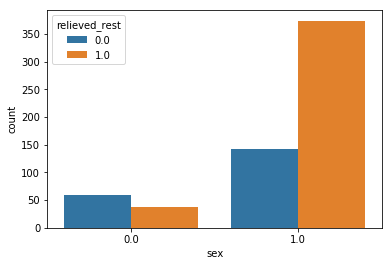

In [16]:
sns.countplot(x='sex', hue='relieved_rest', data=data)

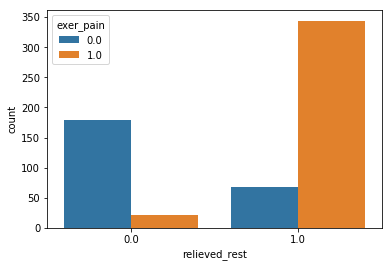

In [17]:
sns.countplot(x='relieved_rest', hue='exer_pain', data=data)

In [18]:
data.loc[(data['relieved_rest'].isnull()) & (data['exer_angina']==1), 'relieved_rest'] = 1
data.loc[(data['relieved_rest'].isnull()) & (data['sex']==1), 'relieved_rest'] = 1
data['relieved_rest'] = data['relieved_rest'].fillna(data['exer_pain'])

Variable `rest_bp` has a fairly Gaussian shape, with one outlier with zero value. Since we know that blood pressures cannot be that low, we will replace these outliers with a null value. Afterward, we will impute missing values with the mean blood pressure.

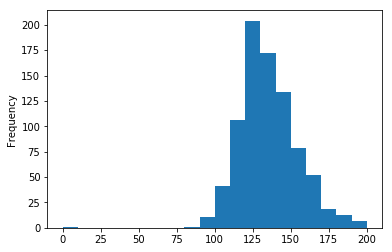

In [19]:
data['rest_bp'].plot.hist(bins=20)

In [20]:
data.loc[data['rest_bp']<25, 'rest_bp'] = np.nan
data['rest_bp'] = data['rest_bp'].fillna(data['rest_bp'].mean())

The histogram of variable `cholesterol` shows ~170 entries of `cholesterol` = 0. Extremely healthy subjects can have very low cholesterol, but it is close to impossible to have cholesterol level at zero. Therefore, we conclude that these zero values are incorrect and need to be replaced by null values.

After this process, we have around 200 null entries in this feature. Since the histogram looks fairly normal, we can impute these missing values with the mean.

202


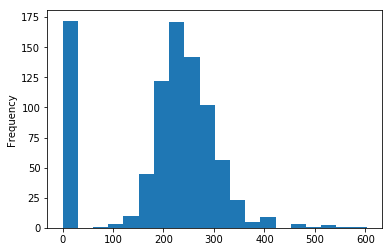

In [21]:
data['cholesterol'].plot.hist(bins=20)
data.loc[data['cholesterol']==0, 'cholesterol'] = np.nan
print(data['cholesterol'].isnull().sum())

In [22]:
data['cholesterol'] = data['cholesterol'].fillna(data['cholesterol'].mean())

Variable `fast_bs` seems heavily unbalanced, with most of the subjects have value `0` (low fasting blood sugar). Since this feature heavily favors one value over another, we will drop this entire column.

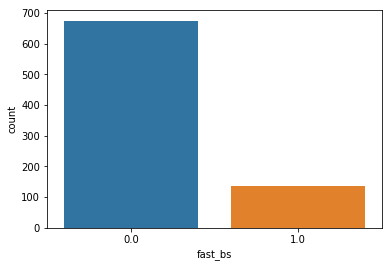

In [23]:
sns.countplot(x='fast_bs', data=data)
data.drop(columns=['fast_bs'], axis=1, inplace=True)

Variable `rest_ecg` only has 2 missing entries, so we will fill these 2 rows with the model `0`. This variable has 3 possible values from 0 to 2, with `0` as normal, `1` as ECG wave abnormality and `2` as left ventricle hypertrophy abnormality. Since both values `1` and `2` indicate abnormality, we will change this feature into a binary variable with value `1` that includes both types of abnormality.

In [24]:
print(data['rest_ecg'].value_counts(dropna=False))
data['rest_ecg'] = data['rest_ecg'].fillna(0)
data.loc[data['rest_ecg']==2, 'rest_ecg'] = 1

0.0    538
2.0    182
1.0    177
NaN      2
Name: rest_ecg, dtype: int64


Variable `exer_hr` looks fairly normally-distributed, so we will impute the missing values with the column mean.

Variable `rest_hr` is right-skewed, but we assume this distribution is normal enough for our purposes. We will perform mean-imputation to fill in the missing entries for this column. Additionally, since we have both `rest_hr` and `exer_hr` columns, we can create a new column `diff_hr` that shows the difference in heart rate between rest and exercise.

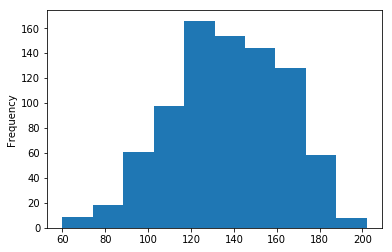

In [25]:
data['exer_hr'].plot.hist()

In [26]:
data['exer_hr'] = data['exer_hr'].fillna(data['exer_hr'].mean())

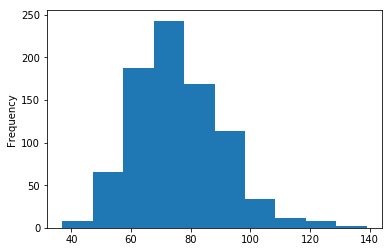

In [27]:
data['rest_hr'].plot.hist()
data['rest_hr'] = data['rest_hr'].fillna(data['rest_hr'].mean())
data['diff_hr'] = data['exer_hr'] - data['rest_hr']

There are two similar features `exer_bp1` and `exer_bp2`, which are two repeated measures of the blood pressure during the exercise protocol. These values are well correlated with each other (correlation = 0.42). Therefore, instead of keeping both variables in the dataset, we will take the average value to create a new feature `exer_bp`. After mean-imputation to fill in for missing values, we will drop the previous 2 columns of repeated blood pressure measures.

Additionally, since we have both columns `rest_bp` and `exer_bp`, we can create a new column `diff_bp` with the difference in blood pressures between rest and exercise conditions.

[[1.         0.42061912]
 [0.42061912 1.        ]]


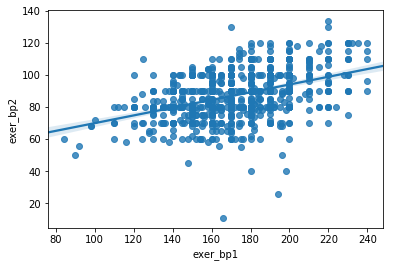

In [28]:
print(np.corrcoef(data.loc[data['exer_bp1'].notnull(), 'exer_bp1'], data.loc[data['exer_bp2'].notnull(), 'exer_bp2']))
sns.regplot(x='exer_bp1', y='exer_bp2', data=data)

In [29]:
data['exer_bp'] = (data['exer_bp1'] + data['exer_bp2']) / 2
data['exer_bp'] = data['exer_bp'].fillna(data['exer_bp'].mean())
data.drop(columns=['exer_bp1','exer_bp2'], axis=1, inplace=True)
data['diff_bp'] = data['exer_bp'] - data['rest_bp']

Variable `exer_angina` only has ~50 missing values, so we can do imputation using the mode `0` to fill in the missing entries.

In [30]:
data['exer_angina'].value_counts(dropna=False)
data['exer_angina'] = data['exer_angina'].fillna(0)

Variable `oldpeak` is an ECG measure, indicating the difference in the ST peak between rest and exercise. Negative values mean resting condition has a higher ST peak compared to exercise. Most values are positive, which makes sense because we expect a stronger heart signal during physical workout.

The histogram shows that around 350 `oldpeak` entries have a zero value, which means that there is no difference in the heart's signal between rest and exercise. This does not make sense since for most living humans, we would expect the heart to beat in a slightly different way at baseline and during stress. More likely, these zero values are missing values and should be replaced by null.

After removing the zero values, the shape of the histogram is fairly normal. Therefore, we will perform mean imputation to fill these null entries.

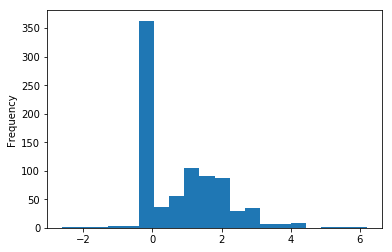

In [31]:
data['oldpeak'].plot.hist(bins=20)
data.loc[data['oldpeak']==0, 'oldpeak'] = np.nan
data['oldpeak'] = data['oldpeak'].fillna(data['oldpeak'].mean())

Variable `exer_slope` indicates the slope of the ST segment in the ECG, with `1` as upsloping, `2` as flat and `3` as downsloping. The one value zero is likely a null value. The 300 null entries are replaced with the mode of the column, which is `2`. 

Additionally, even though `exer_slope` is a categorical variable which theoretically needs to be dummified, it is more ordinal than nominal. Since a flat slope should be indicated by a value in between upslope and downslope, we have decided to leave these as ordinal variable instead of creating dummies for each of the category of slope.

In [32]:
print(data['exer_slope'].value_counts(dropna=False))
data.loc[data['exer_slope']==0, 'exer_slope'] = np.nan
data['exer_slope'] = data['exer_slope'].fillna(2)

2.0    334
NaN    308
1.0    196
3.0     60
0.0      1
Name: exer_slope, dtype: int64


Variable `rest_amp` (height ECG R-wave at rest) only has 474 non-null entries, which is around half of total number of rows. Since we do not believe that imputation of half of the rows can yield robust results. We will drop this column.

The histogram of feature `exer_amp` (height of ECG R-wave during exercise). We do not believe that there can be so many subjects with such low R-wave height, so any value < 30 should be replaced with null values. However, since there are almost 500 subjects with very low `exer_amp`, we will end up having to impute for more than half of the cohort. Therefore, we will also drop this column.

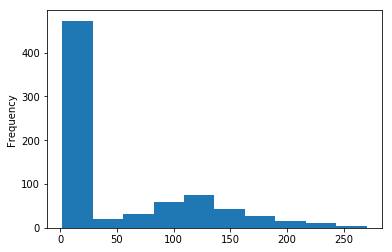

In [33]:
data['exer_amp'].plot.hist()

In [34]:
data.drop(columns=['exer_amp', 'rest_amp'], axis=1, inplace=True)

The features `exer_protocol` and `exer_dur` are more complicated than the rest of the columns. Each patient is prescribed an exercise protocol:
`1` = Bruce; `2` = Kottus; `3` = McHenry; `4` = fast Balke; `5` = Balke; `6` = Noughton; 
`7` = bike 150 kpa min/min; `8` = bike 125 kpa min/min; `9` = bike 100 kpa min/min;
`10` = bike 75 kpa min/min; `11` = bike 50 kpa min/min; `12` = arm ergometer

Even without knowing what some of the named protocols entail, we can already see that there are intensity differences between them, such as between the biking protocols of 50 kpa/min and 150 kpa/min. For the protocols that specify numerical intensity values, we can create an ordinal variable to represent them. However, for protocols such as `Bruce` or `Kottus` treadmill protocol, it is difficult to grade which is more intense.

Additionally, we also see that the `exer_dur` feature varies with the protocol. In a biking exercise, higher intensity usually takes longer to perform, whereas treadmill exercises take around the same amount of time to complete. Additionally, we see that heart rate is similar between treadmill protocols but is proportional to the intensity of biking protocols. Afterward, we will drop both `exer_protocol` and `exer_dur` columns in the final dataset.

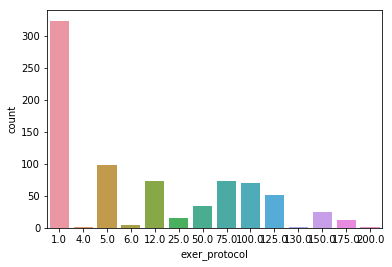

In [35]:
sns.countplot(x='exer_protocol', data=data)

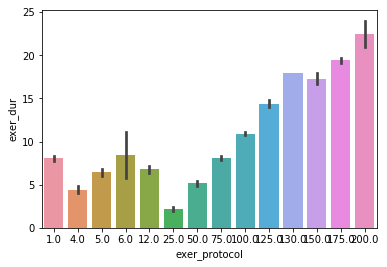

In [36]:
sns.barplot(x='exer_protocol',y='exer_dur',data=data)

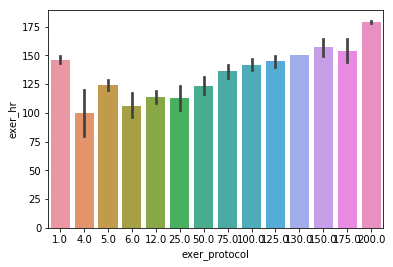

In [37]:
sns.barplot(x='exer_protocol',y='exer_hr',data=data)

After considering the relationship between these different features, we will:
* Create a new binary variable `protocol_type`, `0` for treadmill workout and `1` for biking workout
* Create a continuous variable `protocol_intensity`, which stores the intensity values for biking protocol and has value `0` for treadmill

In [38]:
data['protocol_type'] = 0
data.loc[data['exer_protocol']>12, 'protocol_type'] = 1 # cutoff 12 based on documentation/histogram
data['protocol_intensity'] = 0
data.loc[data['protocol_type']==1, 'protocol_intensity'] = data['exer_protocol']
data.drop(columns=['exer_protocol', 'exer_dur'], axis=1, inplace=True)

Variable `chest_pain` is a categorical variable, with values from 1 to 4:
`1` is a typical angina; `2` is atypical angina; `3` is non-angina pain; `4` is asymptomatic. In this study of heart disease, we only care whether the chest pain originates from an angina or not, so we will create a new binary variable `chest_pain_angina` in which `1` includes typical and atypical angina and `0` includes asymptomatic and non-angina pain.

In [39]:
data['chest_pain_angina'] = 0
data.loc[data['chest_pain']<3, 'chest_pain_angina'] = 1
data.drop(columns=['chest_pain'], axis=1, inplace=True)

Lastly, we will drop `center_id` from the dataset and move our predicted variable `diameter_narrowing` to the beginning to simplify the data exploration and data analysis process.

In [40]:
data.drop(columns=['center_id'], axis=1, inplace=True)

In [41]:
cols_order = np.linspace(0, len(data.columns)-1, len(data.columns))
cols_order[12] = 0
cols_order[0] = 12
data = data.iloc[:, cols_order]
cols_order

array([12.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,  0.,
       13., 14., 15., 16., 17., 18.])

# Data exploration

In [42]:
y_label = 'diameter_narrowing'
x_label = data.iloc[:,1:].columns
x_label_cont = ['age', 'rest_bp', 'cholesterol', 'exer_hr', 'rest_hr', 
                'diff_hr', 'exer_bp', 'diff_bp', 'oldpeak','protocol_intensity']
x_label_cat = [label for label in x_label if label not in x_label_cont]

Let's explore the data before we perform any modeling. In continuous variables, we consider whether these variables are different in patients with heart disease and without heart disease. 

All variables show statistical significance between the two subgroups; therefore, we will not exclude any feature at this point. The less significant variables include `cholesterol`, `rest_bp` and `exer_bp`. Surprisingly, even though baseline blood pressures are not as good indicators of arterial narrowing, the difference `diff_bp` between rest and workout are different between patients and controls.

The variable `protocol_intensity` shows that most subjects with value `0` (treadmill protocol) more likely do have heart disease, whereas value `1` in subjects that perform the biking protocol likely do not have heart disease. Since this is a derived variable, we need to keep an eye on this variable during the data analysis portion to see if it provides any additional benefit to the classification models.

age with and without heart disease has p-value 	4.405509586541005e-17
rest_bp with and without heart disease has p-value 	0.0008820006807615492
cholesterol with and without heart disease has p-value 	0.0005727567725937645
exer_hr with and without heart disease has p-value 	1.9366784805385024e-32
rest_hr with and without heart disease has p-value 	4.6535495080039695e-10
diff_hr with and without heart disease has p-value 	3.912223226737974e-18
exer_bp with and without heart disease has p-value 	0.012757234109778429
diff_bp with and without heart disease has p-value 	5.068285957035123e-08
oldpeak with and without heart disease has p-value 	2.9301055765259298e-08
protocol_intensity with and without heart disease has p-value 	1.1783236197844304e-16


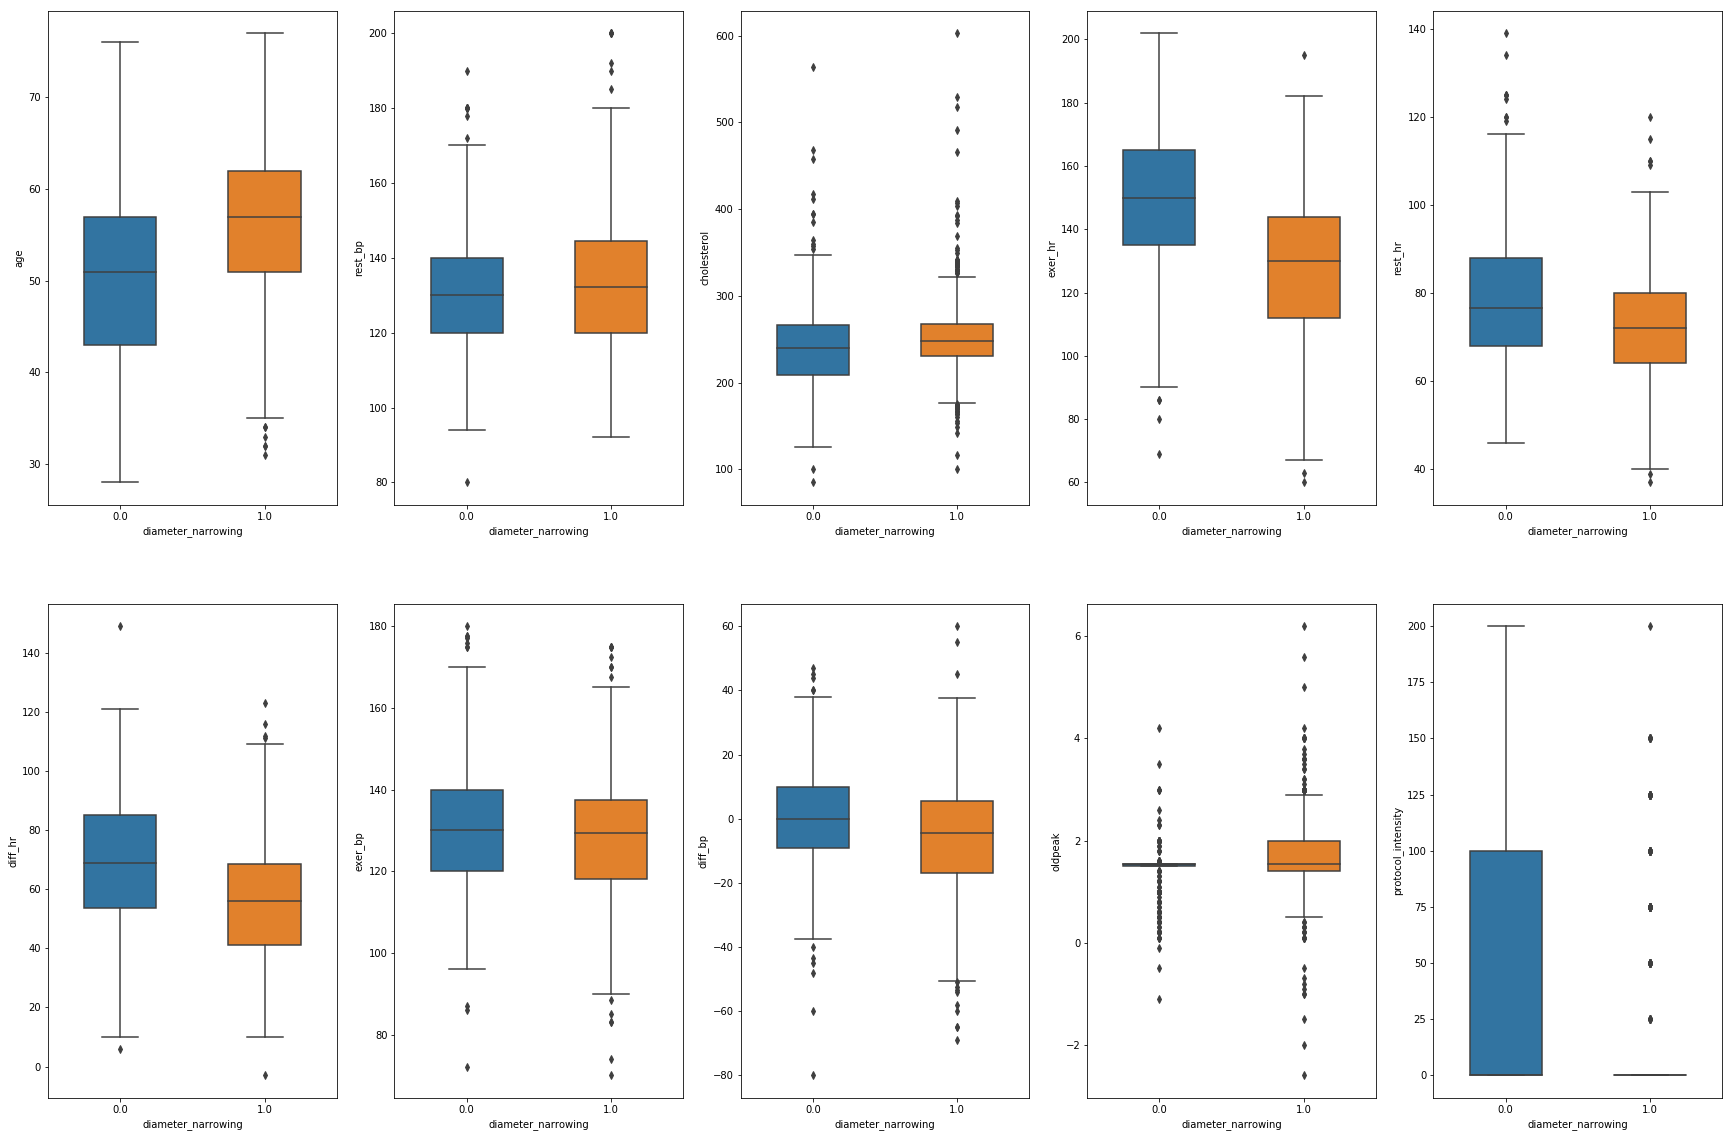

In [43]:
fig, ax = plt.subplots(figsize=(30,20))
for i in range(0, len(x_label_cont)):
    plt.subplot(2,5,i+1)
    sns.boxplot(x=y_label, y=x_label_cont[i], data=data, width=0.5)
    y_1 = data[data[y_label]>0][x_label_cont[i]]
    y_0 = data[data[y_label]<1][x_label_cont[i]]
    ttest = sp.stats.ttest_ind(y_1, y_0, equal_var=False)
    pvalue = ttest.pvalue
    print('{} with and without heart disease has p-value \t{}'.format(x_label_cont[i], pvalue))

For categorical variables, we will look at the contingency tables for each feature using `pd.crosstab` function. Similar to above, most categorical variables show statistical significance difference between subjects without and without diameter narrowing. For example, the `sex` parameter: females (`sex`=0) more likely do not have heart disease, whereas males (`sex`=1) show narrowing of the vascular arteries. This correspond this our general knowledge in which males are more at risk of cardiovascular dysfunction and tend to have a shorter lifespan compared to their female counterpart.

The least significant variable is `rest_ecg` (abnormal ECG at rest), in which the abnormal ECG and the normal ECG subgroups are both more likely to have heart disease. The variable `protocol_type` shows that subject with treadmill protocol (`0`) are more likely to have heart disease, thus confirming our previous observation in the continuous variable `protocol_intensity`.

sex with and without heart disease has p-value 	1.1248904361445055e-21
exer_pain with and without heart disease has p-value 	2.778640368235245e-51
relieved_rest with and without heart disease has p-value 	6.244015544596525e-34
rest_ecg with and without heart disease has p-value 	0.009941151779457388
exer_angina with and without heart disease has p-value 	4.036213815001233e-38
exer_slope with and without heart disease has p-value 	1.4001833378431805e-08
protocol_type with and without heart disease has p-value 	1.3915877851082008e-15
chest_pain_angina with and without heart disease has p-value 	9.59717093722444e-32


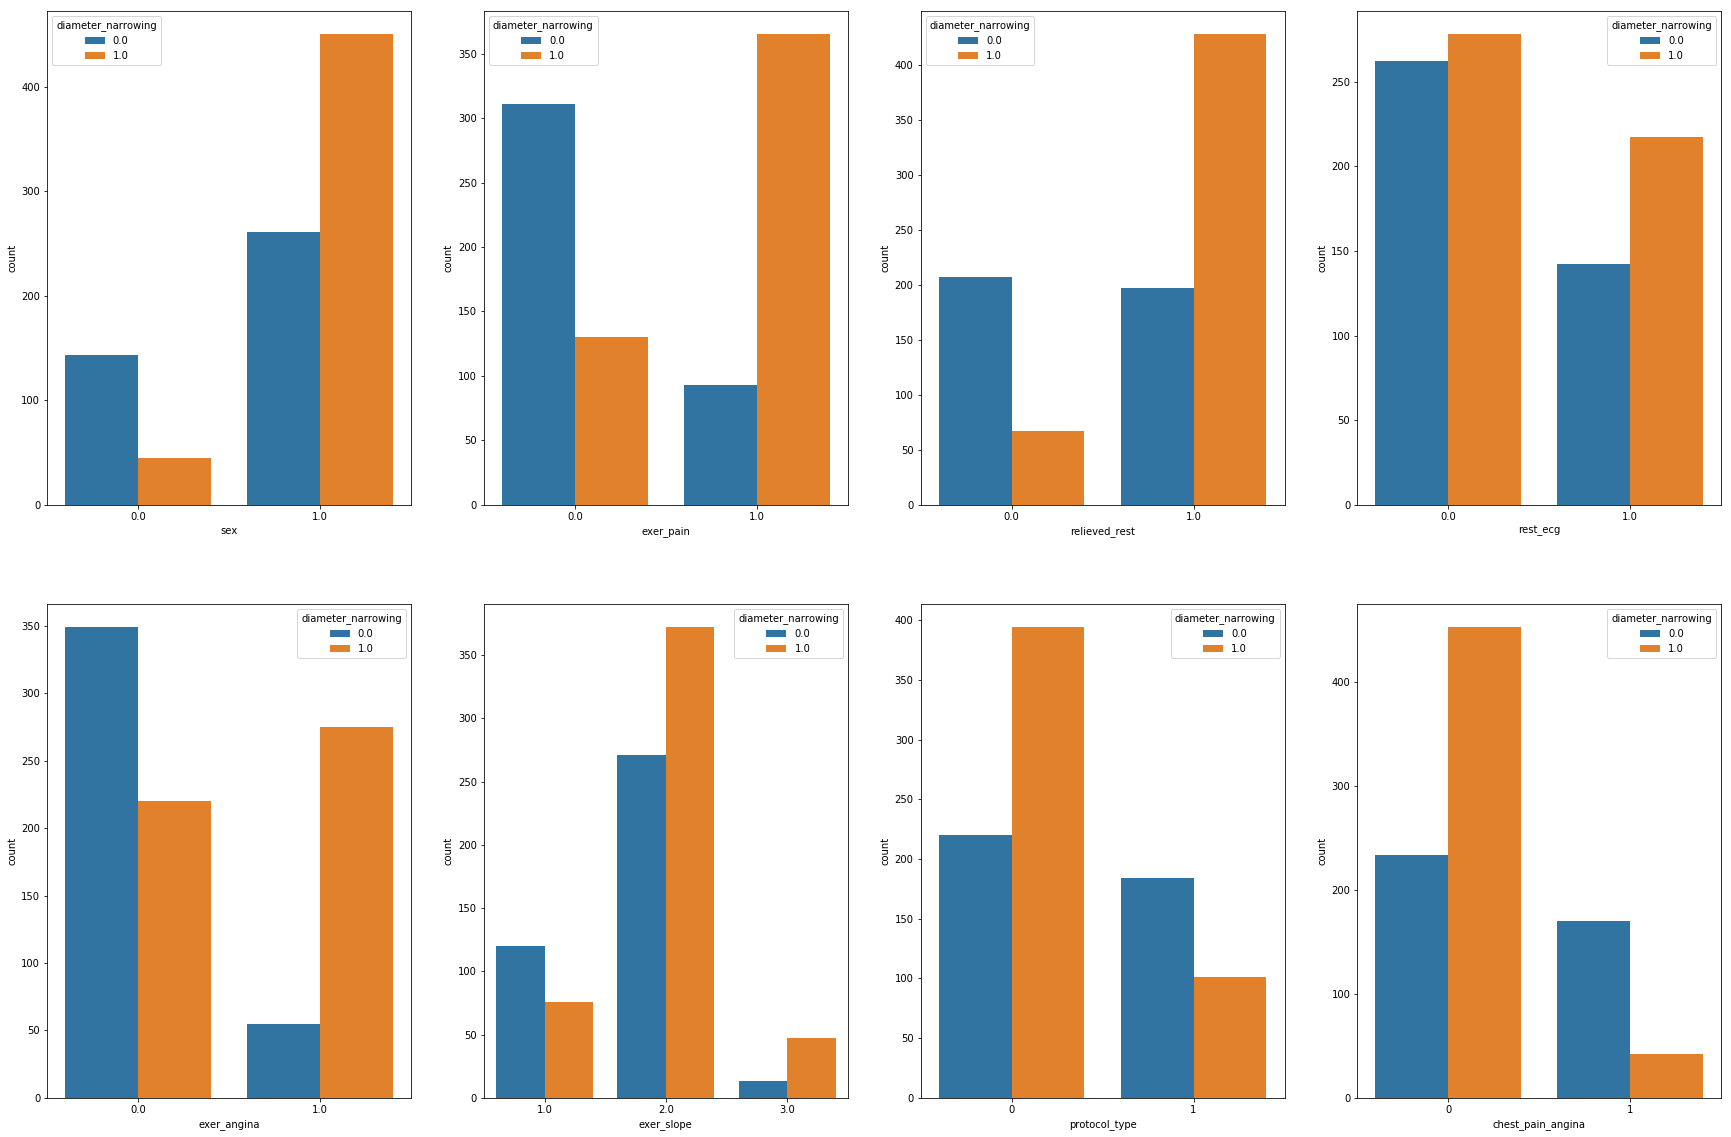

In [44]:
fig, ax = plt.subplots(figsize=(30,20))
for i in range(0, len(x_label_cat)):
    plt.subplot(2,4,i+1)
    sns.countplot(x=x_label_cat[i],hue=y_label,data=data)
    # chi-squared test with contingency table
    chi2test = sp.stats.chi2_contingency(pd.crosstab(data[y_label], data[x_label_cat[i]])) 
    pvalue = chi2test[1]
    print('{} with and without heart disease has p-value \t{}'.format(x_label_cat[i], pvalue))

# Data analysis

For data analysis, we will split our dataset into the train and test set (testing portion = 20%). We will also rescale all predictors and specify the 4 evaluation metrics: *accuracy*, *recall* (or sensitivity, true positive rate), *precision*, and *F1 score*.

In [45]:
x_data = data[x_label]
y_data = data[y_label]
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data, y_data, test_size=0.2, random_state=0)

In [46]:
scaler = preprocessing.StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [47]:
# evaluation metrics
def evaluate_model(model, x_test, y_test):
    y_predict = model.predict(x_test)
    accuracy = metrics.accuracy_score(y_test, y_predict)
    confusion = metrics.confusion_matrix(y_test, y_predict)
    TN, FP, FN, TP = confusion.ravel()
    sensitivity = TP / (TP+FN)
    specificity = TN / (TN+FP)
    recall = sensitivity
    precision = TP / (TP+FP)
    f1_score = 2*(sensitivity*precision)/(sensitivity+precision)
    return [accuracy, recall, precision, f1_score]

For this dataset, we will try 4 out-of-the-box classifiers:
1. Logistic Regression
2. K-Nearest Neighbors
3. Support Vector Machine
4. Random Forest

**Logistic Regression**

In [48]:
logistic = linear_model.LogisticRegression() # out-of-the-box
logistic.fit(x_train, y_train)
evaluate_model(logistic, x_test, y_test)

[0.7944444444444444, 0.7857142857142857, 0.8279569892473119, 0.806282722513089]

**K-Nearest Neighbors**

In [49]:
knn = neighbors.KNeighborsClassifier() # out-of-the-box
knn.fit(x_train, y_train)
evaluate_model(knn, x_test, y_test)

[0.7777777777777778, 0.8061224489795918, 0.79, 0.7979797979797979]

**Support Vector Machine**

In [50]:
svc = svm.SVC() # out-of-the-box
svc.fit(x_train, y_train)
evaluate_model(svc, x_test, y_test)

[0.7777777777777778, 0.8061224489795918, 0.79, 0.7979797979797979]

**Random Forest**

In [51]:
forest = ensemble.RandomForestClassifier() # out-of-the-box
forest.fit(x_train, y_train)
evaluate_model(forest, x_test, y_test)

[0.8055555555555556,
 0.8163265306122449,
 0.8247422680412371,
 0.8205128205128205]

It looks like all models perform very similar, most likely due to the set of features we have chosen. We can look at the `feature_importances_` in the Random Forest model in order to eliminate some unnecessary features.

In [52]:
feature_importance_dict = dict(zip(x_label, forest.feature_importances_))
feature_importance_dict

{'sex': 0.025018268077952998,
 'exer_pain': 0.10647171669842281,
 'relieved_rest': 0.038149979663106987,
 'rest_bp': 0.04934356421809597,
 'cholesterol': 0.07705171485876751,
 'rest_ecg': 0.015119940437368648,
 'exer_hr': 0.09835318747069458,
 'rest_hr': 0.05823880774866926,
 'exer_angina': 0.08243877791329589,
 'oldpeak': 0.05919399569870567,
 'exer_slope': 0.016154733850805056,
 'age': 0.07361987397916808,
 'diff_hr': 0.08279996467812299,
 'exer_bp': 0.05100278368125804,
 'diff_bp': 0.05832701991030197,
 'protocol_type': 0.02994152122189536,
 'protocol_intensity': 0.03322438298474176,
 'chest_pain_angina': 0.045549766908626554}

(array([2., 0., 1., 2., 0., 1., 1., 2., 0., 3., 0., 0., 1., 1., 2., 0., 0.,
        0., 1., 1.]),
 array([0.01511994, 0.01968753, 0.02425512, 0.02882271, 0.0333903 ,
        0.03795788, 0.04252547, 0.04709306, 0.05166065, 0.05622824,
        0.06079583, 0.06536342, 0.06993101, 0.0744986 , 0.07906618,
        0.08363377, 0.08820136, 0.09276895, 0.09733654, 0.10190413,
        0.10647172]),
 <a list of 20 Patch objects>)

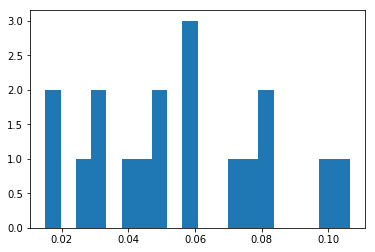

In [53]:
plt.hist(list(feature_importance_dict.values()), bins=20)

Based on the histogram, if we choose a cutoff at 0.04 importance, we see that there are 6 features that contribute the least to the classification. As predicted from our data exploration, `rest_ecg` is not a salient feature. Additionally, both `protocol_type` and `protocol_intensity` do not predict heart disease. This confirms that doctors do not prescribe the protocol based on the observed patient's health, but more likely each doctor has a *favorite* exercise protocol they usually perform.

Let's try to exclude these features and then perform the out-of-the-box classifications again using the four classifiers.

In [54]:
[col for col in feature_importance_dict.keys() if feature_importance_dict[col] <= 0.04]

['sex',
 'relieved_rest',
 'rest_ecg',
 'exer_slope',
 'protocol_type',
 'protocol_intensity']

In [55]:
x_label_subset = [col for col in feature_importance_dict.keys() if feature_importance_dict[col] > 0.04]
x_label_subset_idx = [i for i in range(len(x_label)) if x_label[i] in x_label_subset]
x_train_subset = x_train[:, x_label_subset_idx]
x_test_subset = x_test[:, x_label_subset_idx]

In [56]:
def out_of_the_box(x_train_subset, x_test_subset):
    logistic = linear_model.LogisticRegression(random_state=0) # out-of-the-box
    logistic.fit(x_train_subset, y_train)
    print(evaluate_model(logistic, x_test_subset, y_test))
    
    knn = neighbors.KNeighborsClassifier() # out-of-the-box
    knn.fit(x_train_subset, y_train)
    print(evaluate_model(knn, x_test_subset, y_test))
    
    svc = svm.SVC(random_state=0) # out-of-the-box
    svc.fit(x_train_subset, y_train)
    print(evaluate_model(svc, x_test_subset, y_test))
    
    forest = ensemble.RandomForestClassifier(random_state=0) # out-of-the-box
    forest.fit(x_train_subset, y_train)
    print(evaluate_model(forest, x_test_subset, y_test))
out_of_the_box(x_train_subset, x_test_subset)

[0.7666666666666667, 0.7551020408163265, 0.8043478260869565, 0.7789473684210526]
[0.7555555555555555, 0.7653061224489796, 0.78125, 0.7731958762886597]
[0.7777777777777778, 0.7755102040816326, 0.8085106382978723, 0.7916666666666665]
[0.8, 0.7959183673469388, 0.8297872340425532, 0.8125]


It looks like Random Forest Classifier has improved significantly after better feature selection. Using this subset of features, we now try to optimize these 4 classifiers by tuning hyperparameters with cross-validation to see if we can attain even better performance. 

**Model tuning: Logistic Regression**

In [57]:
solver_values = ['newton-cg', 'lbfgs', 'liblinear']
C_values = [1e-4, 1e-3, 1e-2, 1e-1, 1] # regularization coefficient
param_grid = {'solver': solver_values, 'C': C_values}
logistic = linear_model.LogisticRegression(class_weight='balanced', random_state=0)
logistic_cv = model_selection.GridSearchCV(logistic, param_grid, cv=10)
logistic_cv.fit(x_train_subset, y_train)
evaluate_model(logistic_cv, x_test_subset, y_test)

[0.7611111111111111,
 0.7142857142857143,
 0.8235294117647058,
 0.7650273224043717]

**Model tuning: K-Nearest Neighbors**

In [58]:
n_neighbors_values = np.linspace(1,20,20).astype(int)
param_grid = {'n_neighbors': n_neighbors_values}
knn = neighbors.KNeighborsClassifier()
knn_cv = model_selection.GridSearchCV(knn, param_grid, cv=10)
knn_cv.fit(x_train_subset, y_train)
evaluate_model(knn_cv, x_test_subset, y_test)

[0.7611111111111111,
 0.7755102040816326,
 0.7835051546391752,
 0.7794871794871796]

**Model tuning: SVM**

In [59]:
C_values = [0.1, 1, 10, 100]
kernel_values = ['rbf', 'poly', 'sigmoid']
param_grid = {'C': C_values, 'kernel': kernel_values}
svc = svm.SVC(random_state=0)
svc_cv = model_selection.GridSearchCV(svc, param_grid, cv=10)
svc_cv.fit(x_train_subset, y_train)
evaluate_model(svc_cv, x_test_subset, y_test)

[0.7777777777777778,
 0.7755102040816326,
 0.8085106382978723,
 0.7916666666666665]

**Model tuning: Random Forest**

In [60]:
max_depth_values = [4,8,12]
n_estimators_values = [200, 300, 400]
criterion_values = ['gini', 'entropy']
param_grid = {'max_depth': max_depth_values, 'n_estimators': n_estimators_values, 'criterion': criterion_values}
forest = ensemble.RandomForestClassifier(random_state=0)
forest_cv = model_selection.GridSearchCV(forest, param_grid, cv=10)
forest_cv.fit(x_train_subset, y_train)
evaluate_model(forest_cv, x_test_subset, y_test)

[0.7888888888888889,
 0.7857142857142857,
 0.8191489361702128,
 0.8020833333333333]

In [61]:
evaluate_model(forest_cv, x_train_subset, y_train)

[0.9374130737134909, 0.947103274559194, 0.94, 0.9435382685069009]

Overall, we see that no matter how much we tune the hyperparameters, all classifiers are performing almost equally well, with both `accuracy` and `f1_score` around 80%. At this point, since we are unable to improve these evaluation metrics with tuning, we will stop here. Tuning tends to improve overfitting, but if we look at the metrics for the training set, we see that the `accuracy` and `f1_score` is ~94%, which is higher than the testing metrics but within the expected range. Therefore, we can assume that we are not overfitting much, but rather the choice of features that influence our results.

If we wish to improve this classification model further, our options include improved feature selection, maybe with recursive feature elimination or delving into the science of cardiovascular health to understand which features we would expect to be a biomarker for vascular narrowing. Additional domain knowledge can give us a better idea if we need to derive more meaningful features. As we have seen with `rest_hr` and `exer_hr`, these absolute values do not contribute much to the classification results; however, by evaluating the difference in heart rate between rest and exercise states, our `diff_hr` is one of the more important features in classification.

Other projects that use this dataset usually only include the dataset from Cleveland Clinic. However, in this work, we wish to include data from the 3 additional centers, Switzerland, Hungary and Long Beach. These datasets are less clean with more missing parameters; with more parameter imputation in these datasets, we are more prone the errors. Additionally, as we have stated, the type of protocol `protocol_type` and subsequently `protocol_intensity` do not have a significant impact on the classification, suggesting that the choice of protocol is more dependent on which doctor you have. It is more likely that the choice of protocol is dependent on which center/institution you go to, since doctors in the same hospital tend to perform the same test to synchronize the procedure. Therefore, the heterogeneity of our data could negatively impact the classification: the data is noisy and heterogenous from 4 institutions but not heterogenous enough to even out the biases that originate from a multi-center study.